In [1]:
!pip install pandas -q
!wget https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv

--2022-07-22 12:28:05--  https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71586 (70K) [text/plain]
Saving to: ‘bike.csv.1’

bike.csv.1          100%[===================>]  69,91K  --.-KB/s    in 0,01s   

2022-07-22 12:28:05 (5,48 MB/s) - ‘bike.csv.1’ saved [71586/71586]



In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from alibi.explainers import PartialDependence, plot_pd

%load_ext autoreload
%autoreload 2

### Read and process the dataset

In [3]:
df = pd.read_csv('bike.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


In [4]:
# extract feature names
feature_names = df.columns.tolist()
feature_names.remove('cnt')

# define categorical columns
categorical_columns_names = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

# define categorical and numerical indices for later preprocessing
categorical_columns_indices = [feature_names.index(cn) for cn in categorical_columns_names] 
numerical_columns_indices = [feature_names.index(fn) for fn in feature_names if fn not in categorical_columns_names]

# extract data
X = df[feature_names]
y = df['cnt']

# split data in train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
# define and fit the oridnal encoder
oe = OrdinalEncoder().fit(X_train[categorical_columns_names])

# transform the categorical columns to ordinal encoding
X_train[categorical_columns_names] = oe.transform(X_train[categorical_columns_names])
X_test[categorical_columns_names] = oe.transform(X_test[categorical_columns_names])

# convert data to numpy
X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

# define categorical mappings
categorial_names = {i: list(v) for (i, v) in zip(categorical_columns_indices, oe.categories_)}

In [6]:
# define numerical standard sclaer
num_transf = StandardScaler()

# define categorial one-hot encoder
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in categorial_names.values()],
    drop='first'
)

# define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transf, categorical_columns_indices),
        ('num', num_transf, numerical_columns_indices),
    ],
    sparse_threshold=0
)

In [7]:
# fit preprocessor
preprocessor.fit(X_train)

# preprocess train and test datasets
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

### Train regressor

In [8]:
# define and fit regressor
predictor = RandomForestRegressor(max_depth=8, min_samples_split=5, n_estimators=100)
predictor.fit(X_train_ohe, y_train)

# compute scores
print('Train score: %.2f' % (predictor.score(X_train_ohe, y_train)))
print('Test score: %.2f' % (predictor.score(X_test_ohe, y_test)))

Train score: 0.96
Test score: 0.86


### Partial dependence and individual conditional expectation

In [9]:
def decorator(func):
    def wrapper(X: np.ndarray, *args, **kwargs):
        X_ohe = preprocessor.transform(X)
        return func(X_ohe, *args, *kwargs)
    return wrapper


# prepare predictor to handle preprocessing
predictor.predict = decorator(predictor.predict)

In [10]:
# define explainer
explainer = PartialDependence(predictor=predictor,
                              feature_names=feature_names,
                              categorical_names=categorial_names)

#### View PD of temperature, humidity, wind speed and season

In [11]:
# select temperature, humidity, wind speed, and season
feature_list = [feature_names.index('temp'), 
                feature_names.index('hum'), 
                feature_names.index('windspeed'),
                feature_names.index('season')]

# compute explanations
exp = explainer.explain(X=X_train,
                        features_list=feature_list,
                        kind='average',
                        method='brute',
                        percentiles=(0, 1))

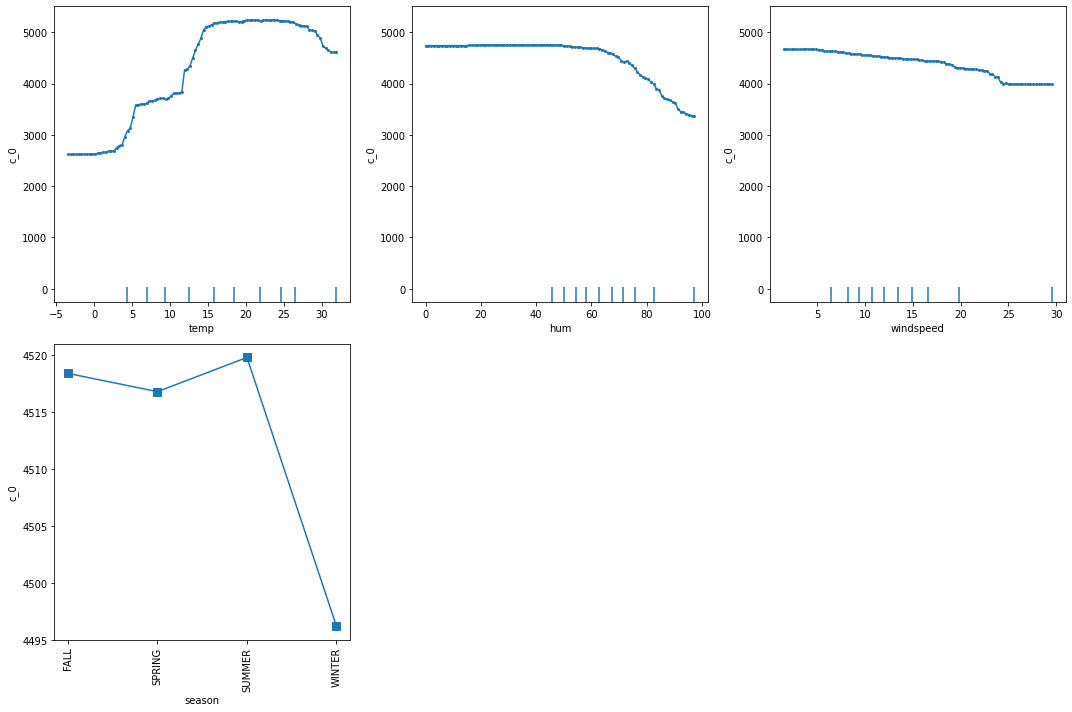

In [12]:
plot_pd(exp=exp,
        n_cols=3,
        sharey='row',
        fig_kw={'figheight': 10, 'figwidth': 15});

#### View PD & ICE of temperature, humidity, wind speed and season

In [13]:
# select temperature, humidity, wind speed, and season
feature_list = [feature_names.index('temp'), 
                feature_names.index('hum'), 
                feature_names.index('windspeed'),
                feature_names.index('season')]

# compute explanations
exp = explainer.explain(X=X_train,
                        features_list=feature_list,
                        kind='both',
                        method='brute',
                        percentiles=(0, 1))

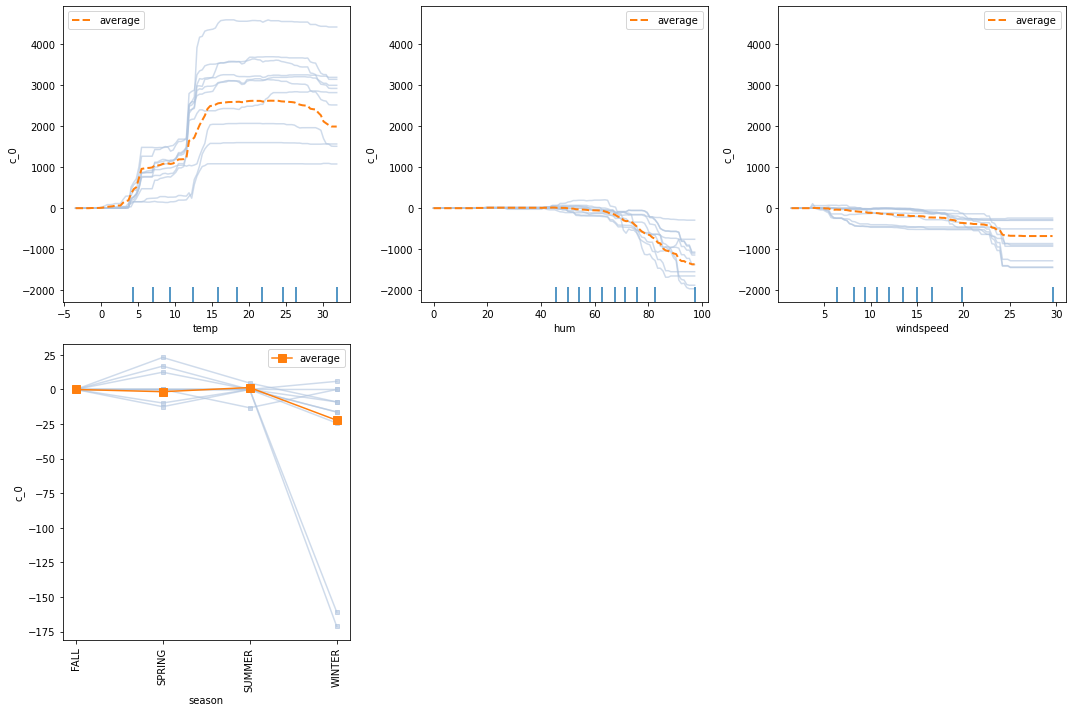

In [31]:
plot_pd(exp=exp,
        n_cols=3,
        n_ice=10,
        sharey='row',
        centered=True,
        fig_kw={'figheight': 10, 'figwidth': 15});

In [19]:
type(np.unique([1,2,3,1]))

numpy.ndarray